# Relationship between Vegetation Indices and Social Vulnerability in Cook County, Illinois

**Authors:** Alex Michels and Tyler Stewart

This notebook walks through calculating vegetation indices VI in Cook County, Illinois and calculating the correlations between the VI and the CDC Social Vulnerability Index (SVI). 

**Note:** Running the full notebook requires an [EarthExplorer account with USGS](http://earthexplorer.usgs.gov/) to download Landsat data, so please create that account before running the notebook. It will be used in the "Our Data / Landsat-9 Data" Section. If you do not have this account or do not want to upload the data, you can use the pre-clipped data if you skip certain portions of the notebook as described in the instructions in "Our Data / Landsat-9 Data."

In [1]:
# Install required packages
#
# Uncomment the last line, run it once, comment it out again, then restart the kernel.
#
# Note that this can cause issues with a few other packages like contextily. The easiest way to delete
# the package when you are done is to restart your server using: 
# File -> Hub Control Panel -> Stop My Server -> Start My Server
#
# !pip install git+https://github.com/jgrss/geowombat

In [2]:
import geopandas as gpd
import geowombat as gw
import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from shapely.geometry import mapping
import statsmodels.api as sm
from tqdm import tqdm

In [3]:
# some useful variables for later
figsize=(8,12)
landsat_data_path = "data/"  # 
clipped_data_dir = "data/clippedLS9"  # where to put our clipped Landsat data later
landsat_bands = "LC09_L1TP_023031_20220703_20220703_02_T1_B{}.TIF"  # format for band files
bands = list(range(1,6))  # bands to use
landsat_paths = [os.path.join(landsat_data_path, landsat_bands.format(x)) for x in bands]  # list of files

# Our Data

## Landsat-9 Data

Our data is a LandSat-9 image from the USGS. It was taken during the day on July 3rd, 2022 with 0-10% cloud cover. **The data can be found [here](https://earthexplorer.usgs.gov/scene/metadata/full/5e81f14f59432a27/LC90230312022184LGN00/), login with USGS to download the "Landsat Collection 2 Level-1 Product Bundle" and upload it to the "data" folder for this project.** Alternatively, skip down to "SVI Data", skipping the "Clipping Landsat-9" section.

Once the data is uploaded, you should be able to use the cell below to extract the data after you upload the tar file to the data folder. Alternatively, navigate to the data in the terminal and decompress the data (`tar -xvf LC09_L1TP_023031_20220703_20220703_02_T1.tar`).

In [4]:
!cd data/ && tar -xvf LC09_L1TP_023031_20220703_20220703_02_T1.tar

LC09_L1TP_023031_20220703_20220703_02_T1_ANG.txt
LC09_L1TP_023031_20220703_20220703_02_T1_B1.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B10.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B11.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B2.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B3.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B4.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B5.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B6.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B7.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B8.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_B9.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_MTL.json
LC09_L1TP_023031_20220703_20220703_02_T1_MTL.txt
LC09_L1TP_023031_20220703_20220703_02_T1_MTL.xml
LC09_L1TP_023031_20220703_20220703_02_T1_QA_PIXEL.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_QA_RADSAT.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_SAA.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_SZA.TIF
LC09_L1TP_023031_20220703_20220703_02_T1_VAA.TIF
LC09_L1TP_023031_

A screenshot from GloVis while selecting the data can be seen below:

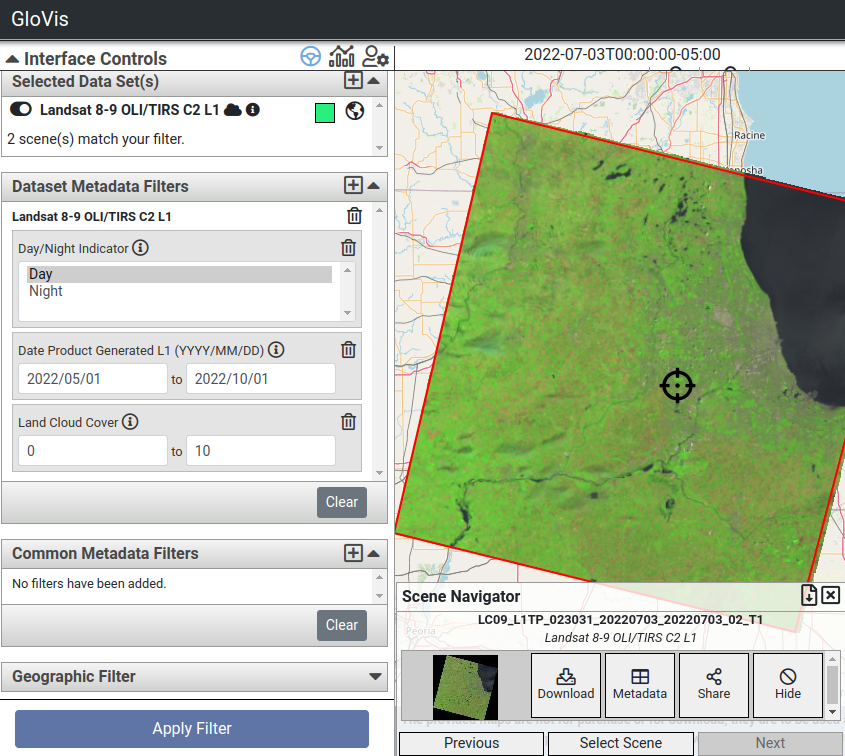


According to the [USGS](https://www.usgs.gov/landsat-missions/landsat-9), the bands in our data are:

* Band 1 Visible (0.43 - 0.45 µm) 30-m
* Band 2 Visible (0.450 - 0.51 µm) 30-m
* Band 3 Visible (0.53 - 0.59 µm) 30-m
* Band 4 Red (0.64 - 0.67 µm) 30-m
* Band 5 Near-Infrared (0.85 - 0.88 µm) 30-m
* Band 6 SWIR 1(1.57 - 1.65 µm) 30-m
* Band 7 SWIR 2 (2.11 - 2.29 µm) 30-m
* Band 8 Panchromatic (PAN) (0.50 - 0.68 µm) 15-m
* Band 9 Cirrus (1.36 - 1.38 µm) 30-m
* Band 10 TIRS 1 (10.6 - 11.19 µm) 100-m
* Band 11 TIRS 2 (11.5 - 12.51 µm) 100-m

Here, we will load the bands and print the object:

In [5]:
with gw.open(landsat_paths, stack_dim="band", band_names=bands) as l9:
    print(l9)

<xarray.DataArray (band: 5, y: 7951, x: 7841)>
dask.array<concatenate, shape=(5, 7951, 7841), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5
  * x        (x) float64 2.703e+05 2.703e+05 2.704e+05 ... 5.055e+05 5.055e+05
  * y        (y) float64 4.743e+06 4.743e+06 4.743e+06 ... 4.504e+06 4.504e+06
Attributes: (12/13)
    transform:           (30.0, 0.0, 270285.0, 0.0, -30.0, 4742715.0)
    crs:                 32616
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    _FillValue:          0.0
    ...                  ...
    offsets:             (0.0,)
    AREA_OR_POINT:       Point
    filename:            ['LC09_L1TP_023031_20220703_20220703_02_T1_B1.TIF', ...
    resampling:          nearest
    _data_are_separate:  1
    _data_are_stacked:   1


Let's plot the data using the true colors:

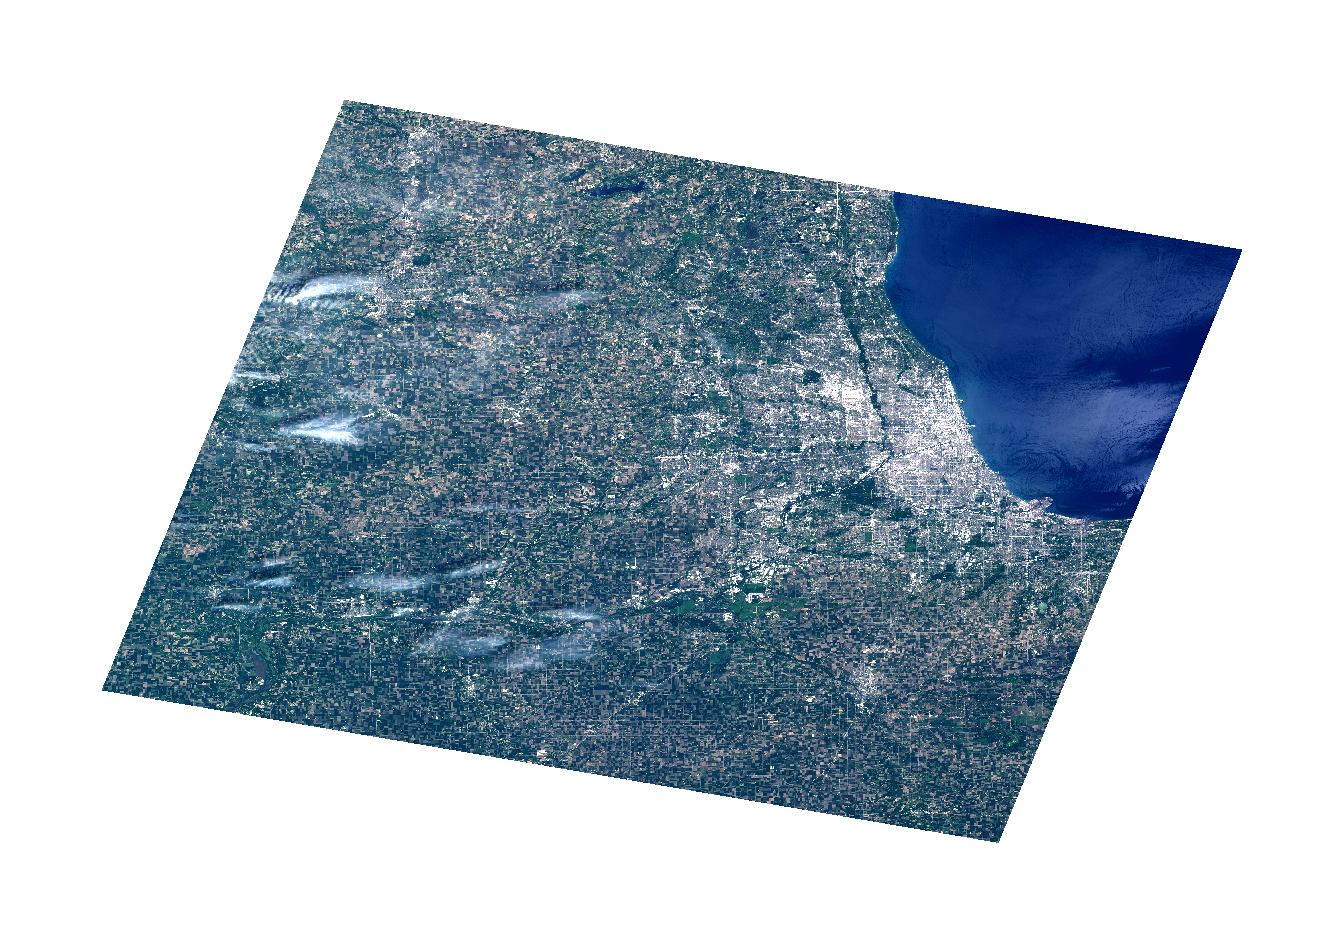

In [6]:
fig, ax = plt.subplots(dpi=200)
with gw.open(landsat_paths, stack_dim="band", band_names=bands) as l9:
    l9.where(l9 != 0).sel(band=[4, 3, 2]).gw.imshow(robust=True, ax=ax)
    ax.set_axis_off()
plt.tight_layout(pad=1)

## SVI Data

The following data is from [CDC/ATSDR SVI 2020](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html). It uses American Community Survey (ACS) data to calculate multiple measures of socio-economic vulnerability:

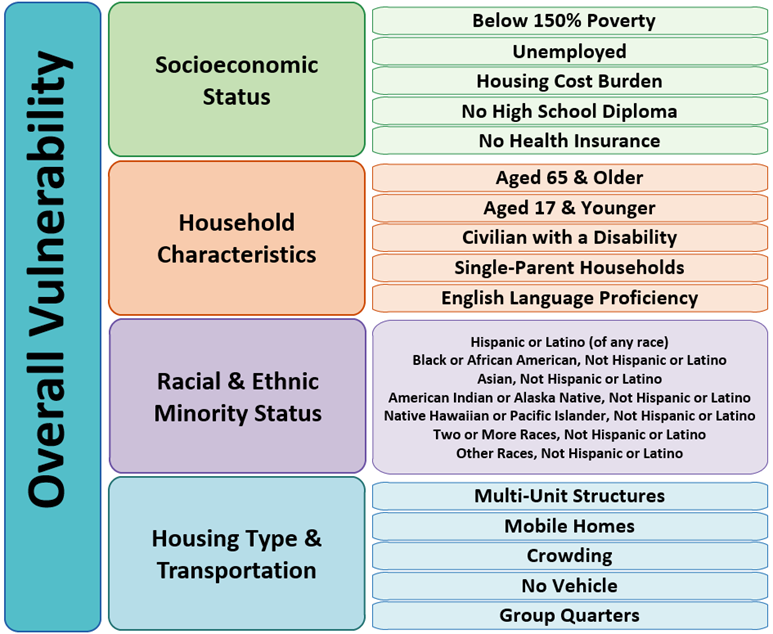

*Image source: [SVI 2020 Documentation](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html)*

In [7]:
# unzip the data
! cd data/ && unzip -o SVI2020_US.zip

Archive:  SVI2020_US.zip
  inflating: SVI2020_US_tract.cpg    
  inflating: SVI2020_US_tract.dbf    
  inflating: SVI2020_US_tract.prj    
  inflating: SVI2020_US_tract.sbn    
  inflating: SVI2020_US_tract.sbx    
  inflating: SVI2020_US_tract.shp    
  inflating: SVI2020_US_tract.shp.xml  
  inflating: SVI2020_US_tract.shx    


In [8]:
# load the data
svi = gpd.read_file("data/SVI2020_US_tract.shp")
# only keep Cook County, IL
svi = svi[svi["STCNTY"] == "17031"]
svi = svi.to_crs("EPSG:32616")
svi.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
25056  17  Illinois      IL  17031   Cook  17031010100   
25057  17  Illinois      IL  17031   Cook  17031010201   
25058  17  Illinois      IL  17031   Cook  17031010202   
25059  17  Illinois      IL  17031   Cook  17031010300   
25060  17  Illinois      IL  17031   Cook  17031010400   

                                         LOCATION  RPL_THEMES  AREA_SQMI  \
25056     Census Tract 101, Cook County, Illinois      0.8528   0.146530   
25057  Census Tract 102.01, Cook County, Illinois      0.9511   0.194775   
25058  Census Tract 102.02, Cook County, Illinois      0.9746   0.135619   
25059     Census Tract 103, Cook County, Illinois      0.8371   0.182442   
25060     Census Tract 104, Cook County, Illinois      0.6962   0.211878   

       E_TOTPOP  ...  F_MUNIT  F_MOBILE  F_CROWD  F_NOVEH  F_GROUPQ  F_THEME4  \
25056      4644  ...        1         0        0        1         0         2   
25057      7488  ...        1         0        1        1         0         3   
25058      3154  ...        1         0        1        1         1         4   
25059      6135  ...        1         0        0        1         1         3   
25060      5193  ...        1         0        0        1         1         3   

       F_TOTAL  SHAPE_STAr  SHAPE_STLe  \
25056        3    0.000038    0.029622   
25057        4    0.000055    0.029522   
25058        5    0.000038    0.025417   
25059        5    0.000050    0.030466   
25060        4    0.000054    0.038068   

                                                geometry  
25056  POLYGON ((443936.001 4652545.254, 444312.984 4...  
25057  POLYGON ((443315.826 4652166.333, 443468.314 4...  
25058  POLYGON ((443961.380 4652152.982, 444006.744 4...  
25059  POLYGON ((444418.780 4652145.271, 444570.448 4...  
25060  POLYGON ((445065.309 4651413.606, 445241.499 4...  

[5 rows x 161 columns]

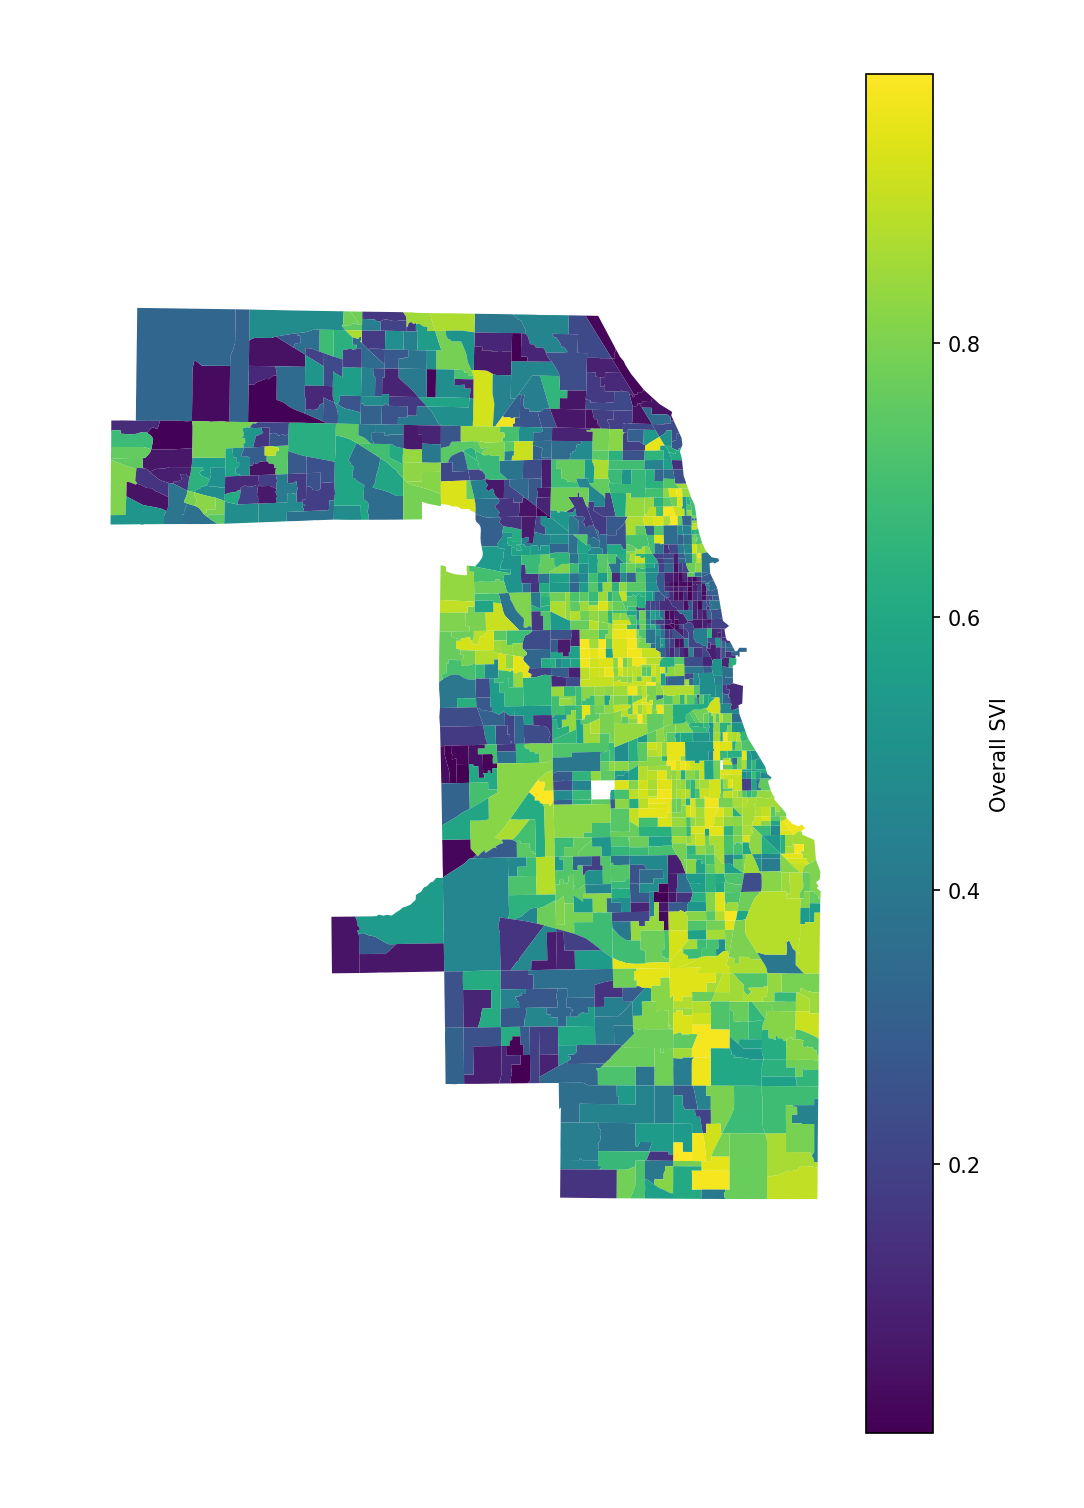

In [9]:
# remove null values
svi_data = svi[svi["RPL_THEMES"] != -999]
# plot it
ax = svi_data.plot(column="RPL_THEMES", figsize=figsize, legend=True,
                   legend_kwds={'label': 'Overall SVI', 'pad': 0.01})
ax.set_axis_off()

If you did not upload the Landsat-9 data, skip the "Clipping Landsat-9" section and go to "Plotting the Clipped Data."

## Clipping Landsat-9

The Landsat-9 data covers much more than Cook County, so in the next few cells we will clip the data and save the raster to a new folder:

In [10]:
# create the folder for the new data
if not os.path.exists(clipped_data_dir):
    os.mkdir(clipped_data_dir)    

In [11]:
# load the bands and clip
for _path in landsat_paths:
    with gw.open(_path) as src:
        _filename = _path.split("/")[-1]
        data = gw.clip(src, svi, mask_data=True)
#         print(data)
        data.gw.to_raster(os.path.join(clipped_data_dir, _filename), overwrite=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.71it/s]


## Plotting the Clipped Data

Let's plot our new data:

In [12]:
# list the files
clipped_paths = [os.path.join(clipped_data_dir, landsat_bands.format(x)) for x in bands]
clipped_paths

['data/clippedLS9/LC09_L1TP_023031_20220703_20220703_02_T1_B1.TIF',
 'data/clippedLS9/LC09_L1TP_023031_20220703_20220703_02_T1_B2.TIF',
 'data/clippedLS9/LC09_L1TP_023031_20220703_20220703_02_T1_B3.TIF',
 'data/clippedLS9/LC09_L1TP_023031_20220703_20220703_02_T1_B4.TIF',
 'data/clippedLS9/LC09_L1TP_023031_20220703_20220703_02_T1_B5.TIF']

In [13]:
# load the data and print it again
with gw.open(clipped_paths, stack_dim="band", band_names=bands) as src:
    print(src)

<xarray.DataArray (band: 5, y: 2553, x: 2035)>
dask.array<concatenate, shape=(5, 2553, 2035), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5
  * x        (x) float64 3.954e+05 3.954e+05 3.954e+05 ... 4.564e+05 4.564e+05
  * y        (y) float64 4.668e+06 4.668e+06 4.668e+06 ... 4.591e+06 4.591e+06
Attributes: (12/13)
    transform:           (30.0, 0.0, 395370.0, 0.0, -30.0, 4667670.0)
    crs:                 32616
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    filename:            ['LC09_L1TP_023031_20220703_20220703_02_T1_B1.TIF', ...
    resampling:          nearest
    _data_are_separate:  1
    _data_are_stacked:   1


Now that we have clipped the data, let's plot it:

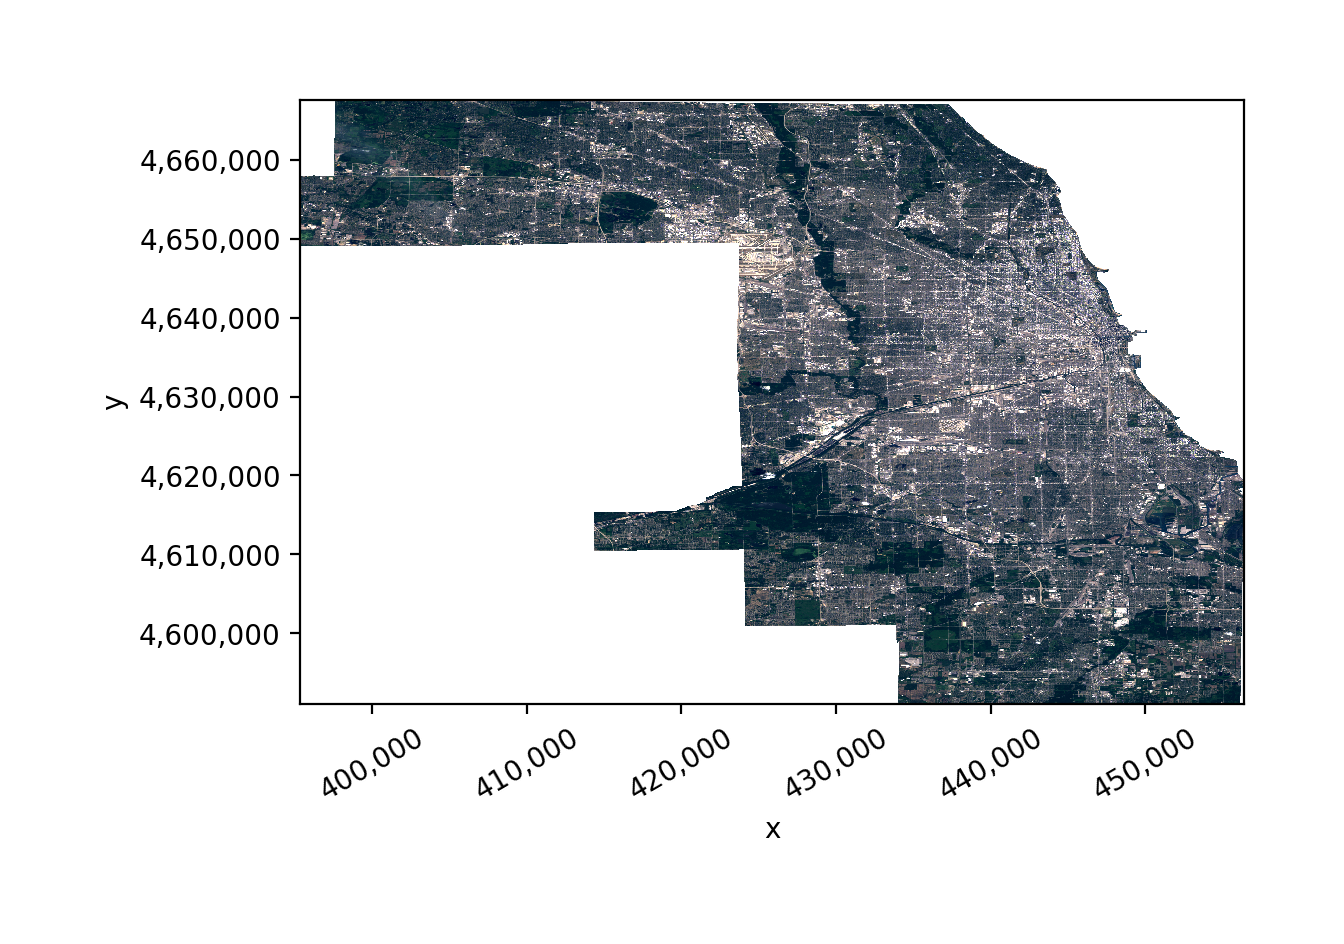

In [14]:
fig, ax = plt.subplots(dpi=200)
with gw.open(clipped_paths, stack_dim="band", band_names=bands) as l9:
    l9.where(l9 != 0).sel(band=[4, 3, 2]).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

# Vegetation Index Calculation

We are going to use 4 different vegetation indices built into geowombat:

* Enhanced Vegetation Index (EVI) $$EVI = 2.5 \times \frac{NIR-red}{NIR\times 6 \times red -7.5\times blue +1}$$
* Two-Band Enhanced Vegetation Index (EVI2) $$EVI2 = 2.5\times\frac{NIR-red}{NIR+1+2.4\times red}$$
* Kernel Normalized Difference Vegetation Index (KNDVI) $$kNDVI=\tanh(NDVI^{2})$$
* Normalized Difference Vegetation Index (NDVI) $$NDVI=\frac{NIR-red}{NIR+red}$$

In [15]:
# https://landsat.gsfc.nasa.gov/satellites/landsat-9/landsat-9-instruments/landsat-9-spectral-specifications/
band_labels = ["coastal", "blue", "green", "red", "nir"]
# methods: https://geowombat.readthedocs.io/en/latest/api.html
methods = ['evi', 'evi2', 'kndvi', 'ndvi']

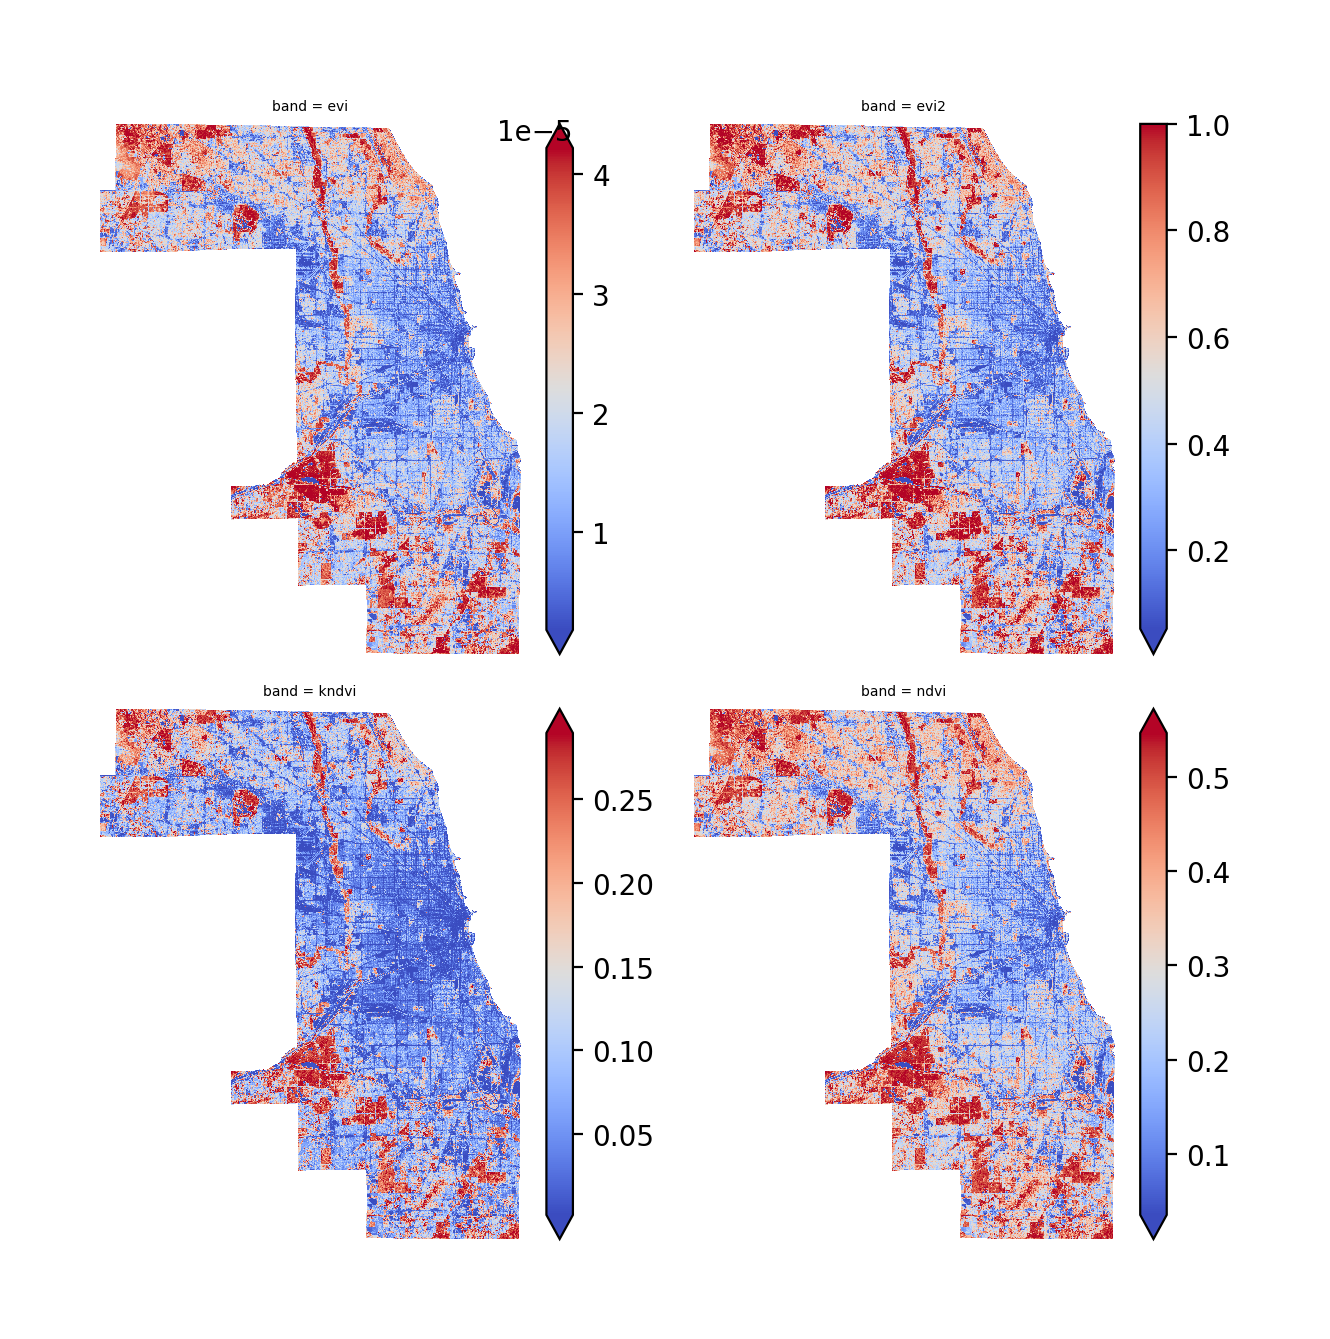

In [16]:
results = []
fig, axes = plt.subplots(2, 2, dpi=200, figsize=(6,6))
for i, method in enumerate(methods):
    ax = axes.flatten()[i]
    with gw.open(clipped_paths, stack_dim="band",
                 band_names=band_labels) as l9:
        function2call = getattr(l9.gw, method)
        results.append(function2call())  # call the method
        cook_analysis = results[i]
        cook_analysis.sel(band=[method]).gw.imshow(cmap='coolwarm', robust=True, ax=ax)
        ax.set_axis_off()
plt.tight_layout()
plt.savefig('test.jpg')

Now that we have calculated the indices, we need a way to create a measure for each census tract to compare against social vulnerability. We will follow a similar approach to [Johnson et. al. (2012)](https://doi.org/10.1016/j.apgeog.2012.04.006) by calculating the mean value for each geographic unit.

We need to clip the data to the census tracts and calculate the mean value for each census tract. This clipping takes a few minutes.

In [17]:
mean_values = {}
mean_values['FIPS'] = svi["FIPS"]  # create id column
for i, method in enumerate(methods):
    mean_values[method] = []
    with gw.open(clipped_paths, stack_dim="band",
                 band_names=band_labels) as l9:
        cook_res = results[i]
#         print(cook_res)
        for fips in tqdm(svi["FIPS"], desc=f"Mean for {method}"):
            ct_row = svi[svi["FIPS"] == fips]
            ct_data = gw.clip(cook_res, ct_row, mask_data=True)
            ct_mean = ct_data.mean()
            mean_values[method].append(float(ct_mean))

Mean for ndvi: 100%|██████████████████████████████████████████████████████████████| 1331/1331 [01:13<00:00, 18.10it/s]


Given the dictionary of data we have created, let's convert it to a dataframe:

In [18]:
vi_per_ct = pd.DataFrame.from_dict(mean_values)
vi_per_ct = vi_per_ct.set_index('FIPS')
vi_per_ct.head()

evi      evi2     kndvi      ndvi
FIPS                                               
17031010100  0.000010  0.259770  0.034343  0.160746
17031010201  0.000013  0.348039  0.053378  0.211666
17031010202  0.000012  0.298523  0.043594  0.182631
17031010300  0.000011  0.300703  0.041540  0.184251
17031010400  0.000012  0.315523  0.049104  0.186778

Next, let's merge our VI data to our SVI data:

In [19]:
# Merge with SVI data
merged = svi.merge(vi_per_ct, left_on="FIPS", right_index=True)
merged.head()

ST     STATE ST_ABBR STCNTY COUNTY         FIPS  \
25056  17  Illinois      IL  17031   Cook  17031010100   
25057  17  Illinois      IL  17031   Cook  17031010201   
25058  17  Illinois      IL  17031   Cook  17031010202   
25059  17  Illinois      IL  17031   Cook  17031010300   
25060  17  Illinois      IL  17031   Cook  17031010400   

                                         LOCATION  RPL_THEMES  AREA_SQMI  \
25056     Census Tract 101, Cook County, Illinois      0.8528   0.146530   
25057  Census Tract 102.01, Cook County, Illinois      0.9511   0.194775   
25058  Census Tract 102.02, Cook County, Illinois      0.9746   0.135619   
25059     Census Tract 103, Cook County, Illinois      0.8371   0.182442   
25060     Census Tract 104, Cook County, Illinois      0.6962   0.211878   

       E_TOTPOP  ...  F_GROUPQ  F_THEME4  F_TOTAL  SHAPE_STAr  SHAPE_STLe  \
25056      4644  ...         0         2        3    0.000038    0.029622   
25057      7488  ...         0         3        4    0.000055    0.029522   
25058      3154  ...         1         4        5    0.000038    0.025417   
25059      6135  ...         1         3        5    0.000050    0.030466   
25060      5193  ...         1         3        4    0.000054    0.038068   

                                                geometry       evi      evi2  \
25056  POLYGON ((443936.001 4652545.254, 444312.984 4...  0.000010  0.259770   
25057  POLYGON ((443315.826 4652166.333, 443468.314 4...  0.000013  0.348039   
25058  POLYGON ((443961.380 4652152.982, 444006.744 4...  0.000012  0.298523   
25059  POLYGON ((444418.780 4652145.271, 444570.448 4...  0.000011  0.300703   
25060  POLYGON ((445065.309 4651413.606, 445241.499 4...  0.000012  0.315523   

          kndvi      ndvi  
25056  0.034343  0.160746  
25057  0.053378  0.211666  
25058  0.043594  0.182631  
25059  0.041540  0.184251  
25060  0.049104  0.186778  

[5 rows x 165 columns]

As a test, let's try plotting the mean VI for each census tract:

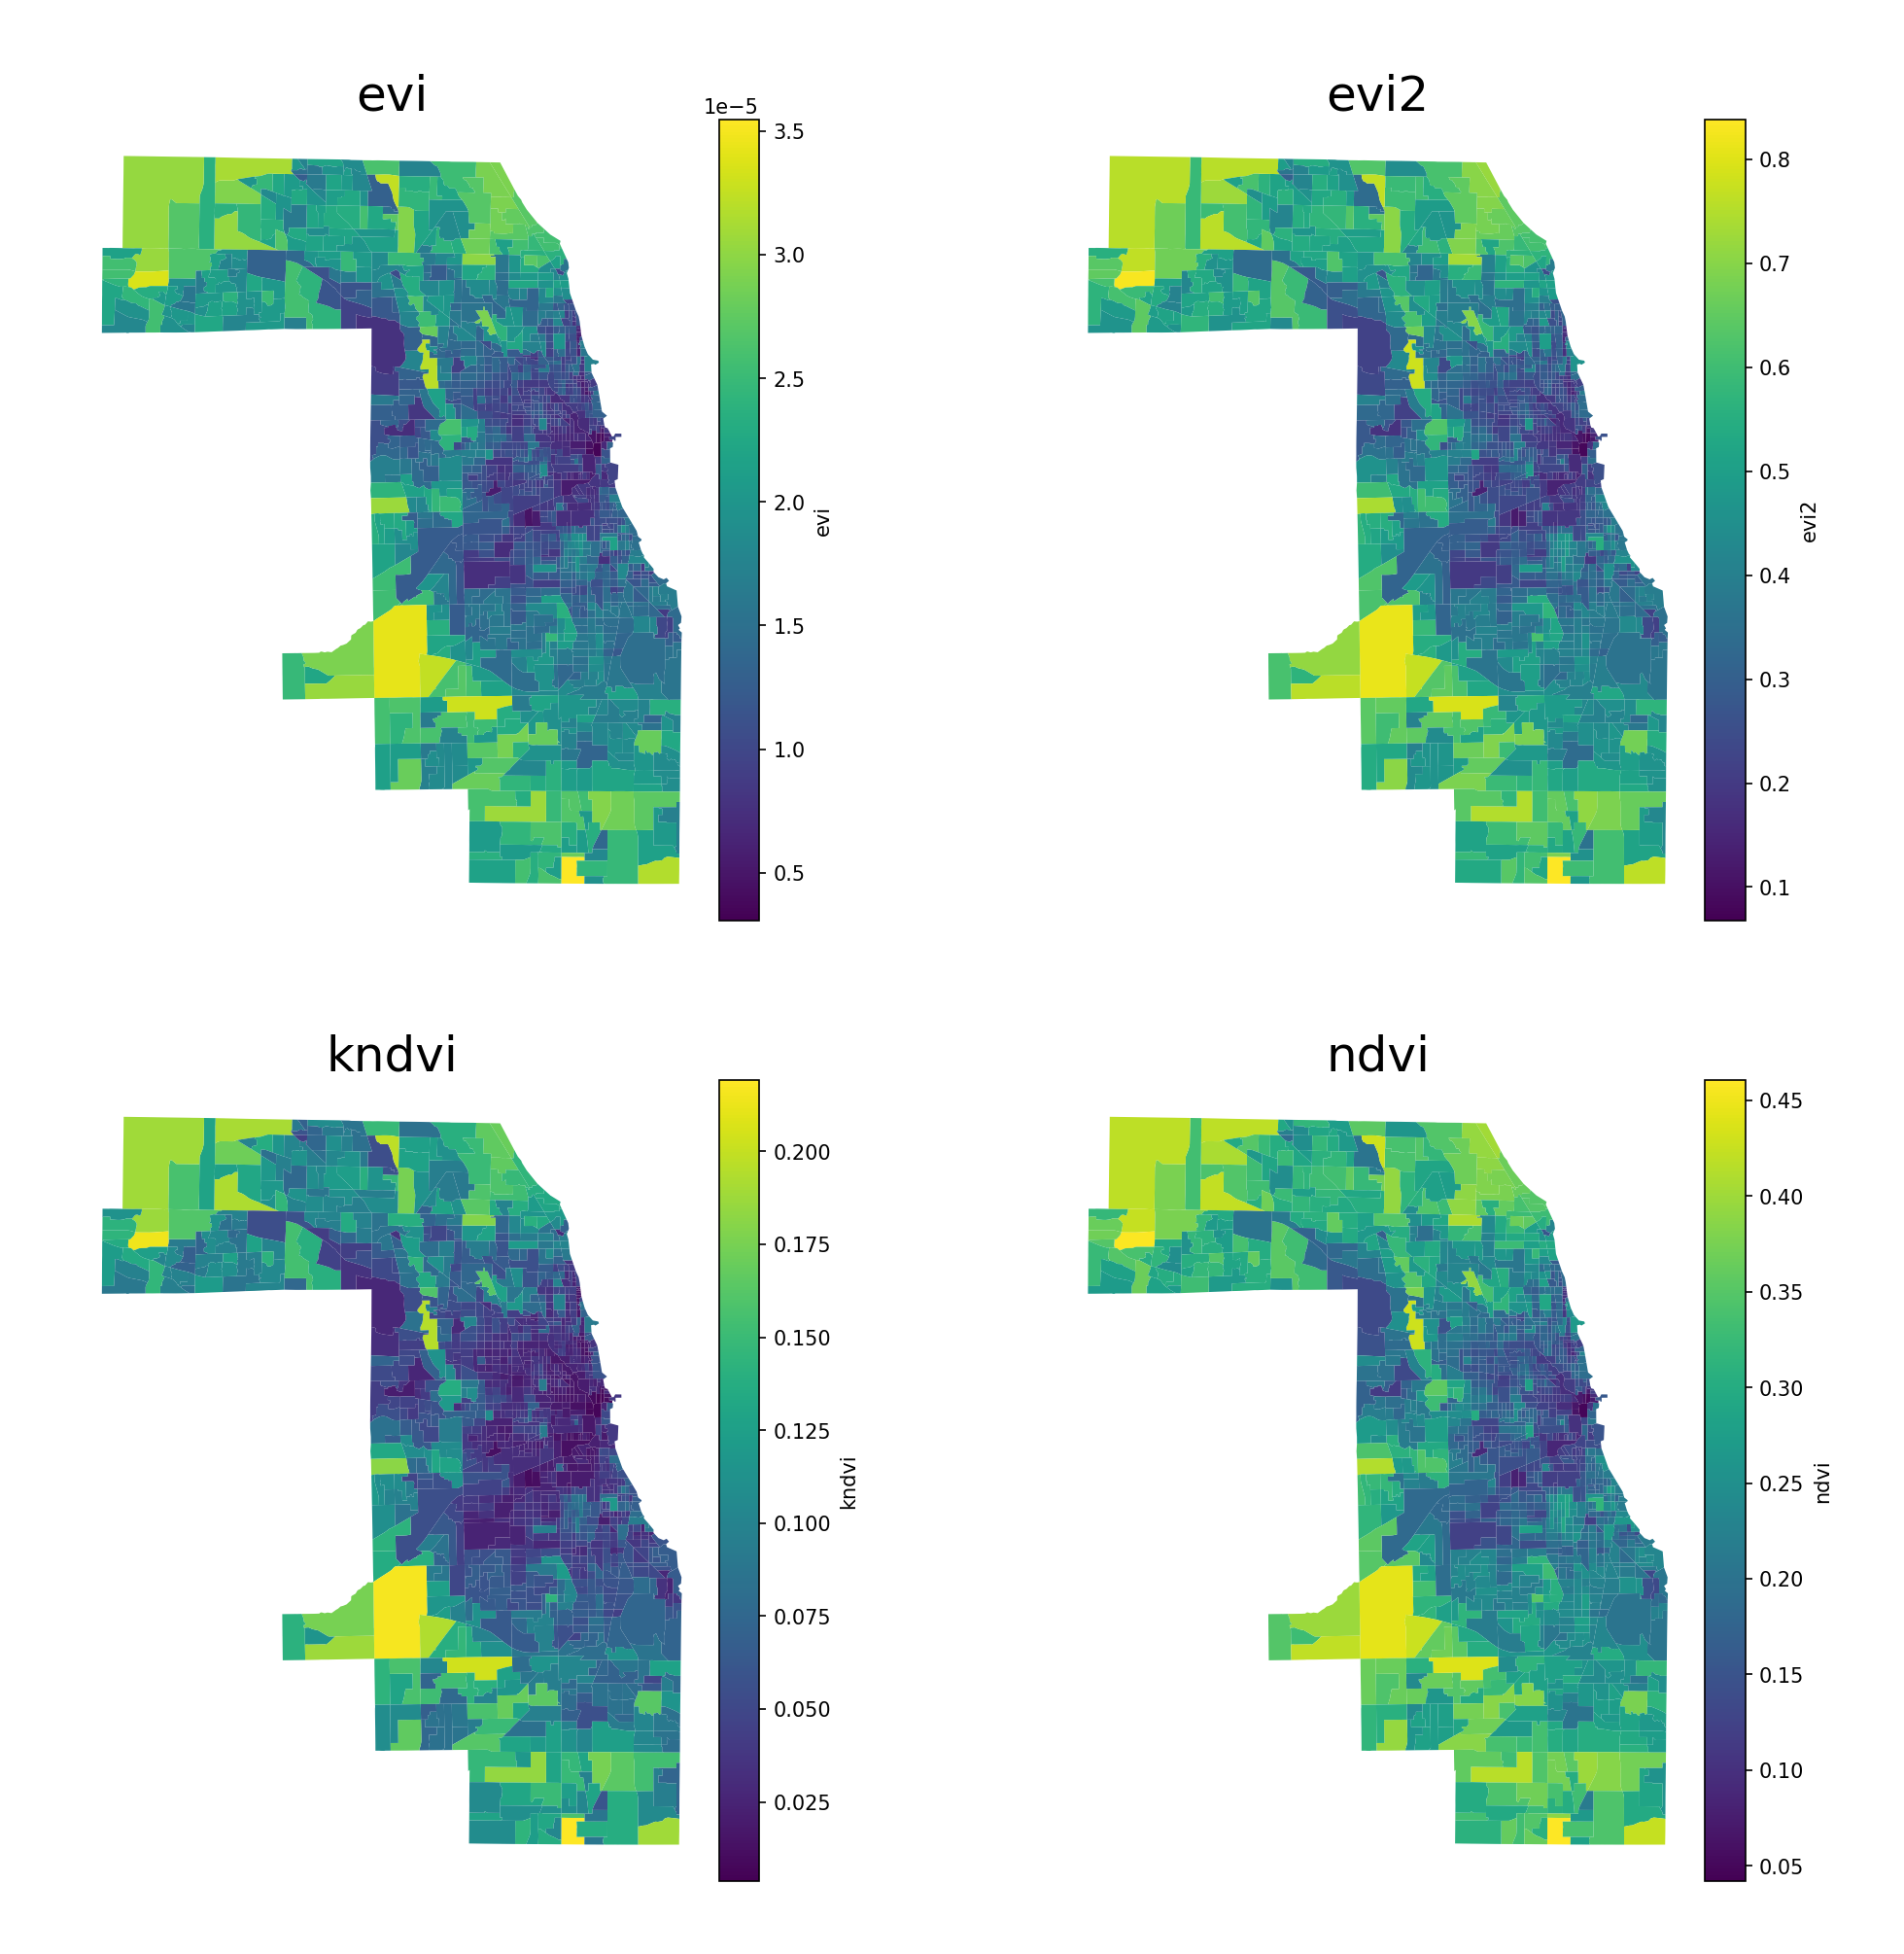

In [20]:
# plot the ndvi
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for ax, method in zip(axes.flatten(), methods):
    ax = merged.plot(ax=ax, column=method, figsize=figsize, legend=True,
                    legend_kwds={'label': method, 'pad': 0.01})
    ax.set_axis_off()
    ax.set_title(method, fontsize=24)

# Correlations

Now we have a mean VI and a SVI data for each census tract! That is everything we need to calculate the correlations. To begin, we will calculate a correlogram to visualize the Spearman's Rank Correlation between our variables:

<AxesSubplot:>

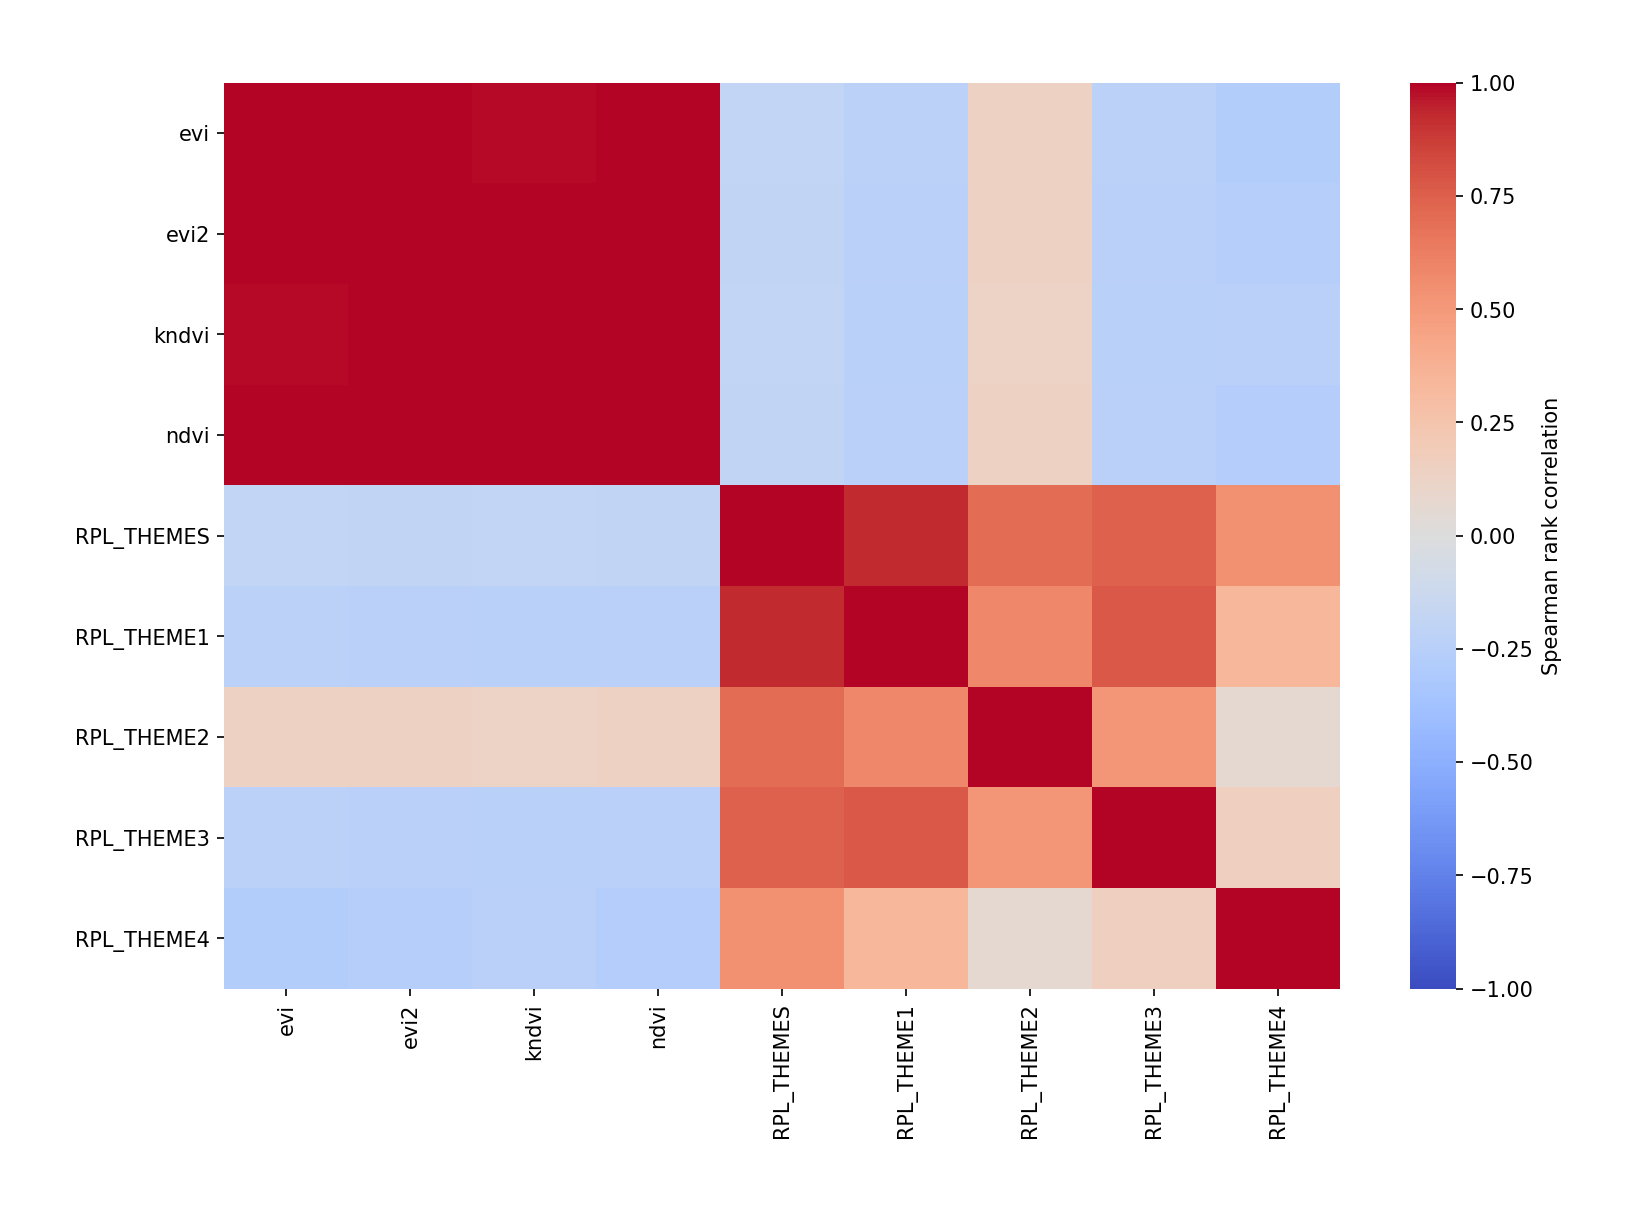

In [21]:
rs_vars = methods  # the VI variables
svi_vars = ["RPL_THEMES", "RPL_THEME1", "RPL_THEME2", "RPL_THEME3", "RPL_THEME4"]  # SVI variables
all_vars = rs_vars + svi_vars  # add them together
tmp = merged[all_vars]  # get a dataframe with just our data of interest
fig, ax = plt.subplots(figsize=(12,8))
# plot the correlogram with seaborn!
sns.heatmap(tmp.corr(method='spearman'), center=0, vmin=-1, vmax=1, cmap='coolwarm',
            cbar_kws={'label': 'Spearman rank correlation'}, ax=ax)

<AxesSubplot:>

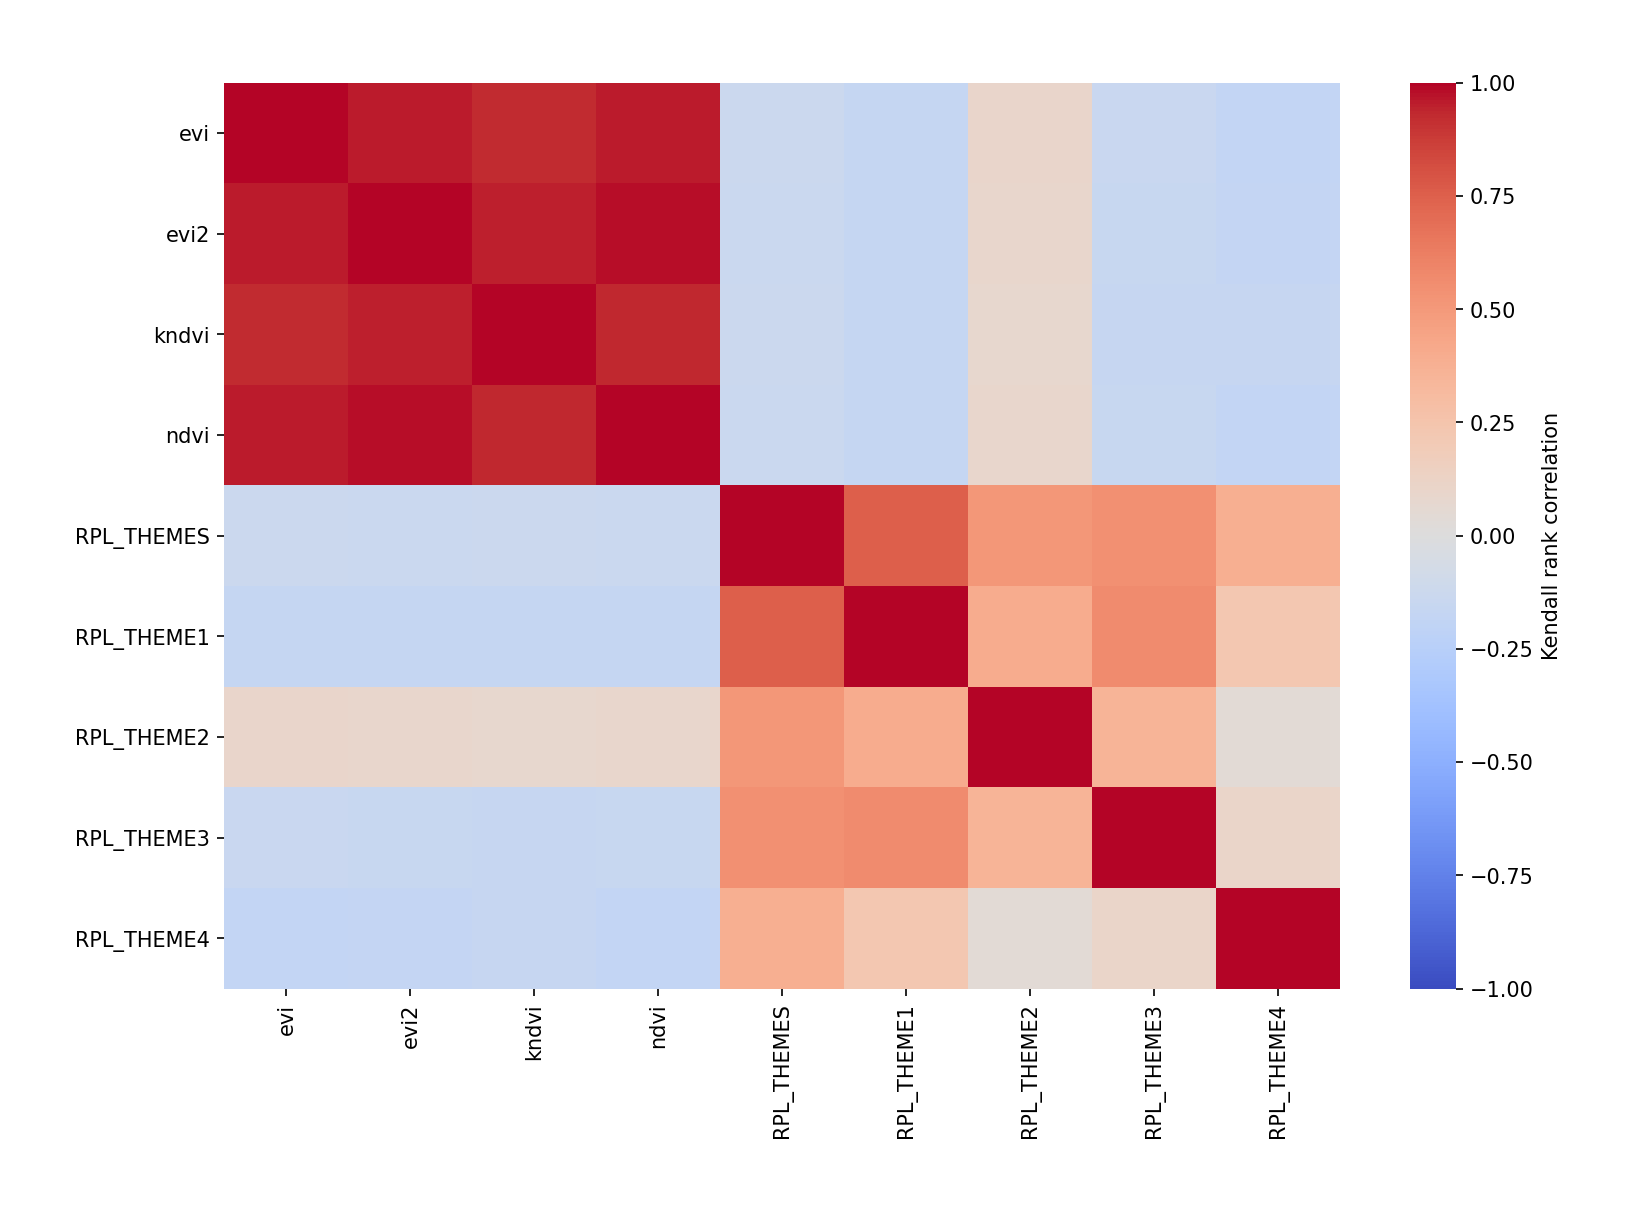

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
# plot the correlogram with seaborn!
sns.heatmap(tmp.corr(method='kendall'), center=0, vmin=-1, vmax=1, cmap='coolwarm',
            cbar_kws={'label': 'Kendall rank correlation'}, ax=ax)

Unsurprisingly, it appears that the vegetation indices are all highly correlated with each other. The social vulnerability indices also seem to be relatively highly correlated with the exception of 2 and 4. The correlations between the VI and SVI seems to be slightly negative for all by Theme 2 (Household Characteristics).

However, we need to check if our correlations are statistically significant at a reasonable level of significance. We will use two different correlation metrics (Kendall's $\tau$ and Spearson's Rank) and perform correlations between many pairs of variables, this means we are running many tests. When running many statistical tests, we run into the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). To avoid these errors, we will use [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) which is a simple and conservative method to correct p-values by multiplying by the number of tests.

In [23]:
def get_tau_spearman(df: pd.DataFrame, x: str, y: str, n_tests: int=1):
    """
    Simple helper function to calculate Kendall's \tau and Spearman's Rank correlation.
    
    Args:
        df (pd.DataFrame): dataframe of data
        x (str): the first variable for the analysis
        y (str): the second variable for the analysis
        n_tests (int): the number of tests performed, used for Bonferroni correction
    
    Returns:
        tuple: (variable, <coefficient, p-value for each method>)
    """
    k_coef, k_pval = scipy.stats.kendalltau(df[x], df[y])
    s_coef, s_pval = scipy.stats.spearmanr(df[x], df[y])
    return (y, k_coef, k_pval * n_tests, s_coef, s_pval * n_tests)

Now that we have our helper function, we can use it to calculate the correlations and p-values:

In [24]:
npairs = len(rs_vars) * len(svi_vars)
ntests = npairs * 2  # 2 correlation methods
for _rs_var in rs_vars:
    table = f"|{_rs_var} | Kendall's Tau | p-value | Spearman | p-value |\n|-|-|-|-|-|\n"
    for var in svi_vars:
        corrs = get_tau_spearman(merged, _rs_var, var, n_tests=ntests)
        table += "|{}|{:.3f}|{:.2e}|{:.3f}|{:.2e}|\n".format(*corrs)
    display(Markdown(table))

|evi | Kendall's Tau | p-value | Spearman | p-value |
|-|-|-|-|-|
|RPL_THEMES|-0.133|1.69e-11|-0.187|2.31e-10|
|RPL_THEME1|-0.165|9.57e-18|-0.234|2.19e-16|
|RPL_THEME2|0.095|8.67e-06|0.148|2.55e-06|
|RPL_THEME3|-0.148|2.76e-14|-0.227|2.09e-15|
|RPL_THEME4|-0.186|1.08e-22|-0.278|1.78e-23|


|evi2 | Kendall's Tau | p-value | Spearman | p-value |
|-|-|-|-|-|
|RPL_THEMES|-0.134|8.53e-12|-0.189|1.31e-10|
|RPL_THEME1|-0.170|7.87e-19|-0.240|2.43e-17|
|RPL_THEME2|0.089|5.21e-05|0.138|1.68e-05|
|RPL_THEME3|-0.155|1.12e-15|-0.237|7.65e-17|
|RPL_THEME4|-0.175|5.36e-20|-0.262|1.06e-20|


|kndvi | Kendall's Tau | p-value | Spearman | p-value |
|-|-|-|-|-|
|RPL_THEMES|-0.132|1.89e-11|-0.187|2.48e-10|
|RPL_THEME1|-0.171|3.25e-19|-0.243|1.03e-17|
|RPL_THEME2|0.084|1.70e-04|0.131|6.06e-05|
|RPL_THEME3|-0.162|3.92e-17|-0.247|2.33e-18|
|RPL_THEME4|-0.159|1.48e-16|-0.239|3.74e-17|


|ndvi | Kendall's Tau | p-value | Spearman | p-value |
|-|-|-|-|-|
|RPL_THEMES|-0.136|5.02e-12|-0.191|8.71e-11|
|RPL_THEME1|-0.170|6.96e-19|-0.240|2.38e-17|
|RPL_THEME2|0.089|4.02e-05|0.140|1.19e-05|
|RPL_THEME3|-0.153|2.67e-15|-0.234|1.80e-16|
|RPL_THEME4|-0.180|3.56e-21|-0.269|6.07e-22|


From the results, we see that all of our tests are statistically significant for $\alpha=0.0001$! This provides strong evidence that there is a relationship between vegetation and social vulnerability in Cook County, IL. 

We observe a negative relationship for all but Theme 2: Household Characteristics. The negative relationships with Overall Vulnerability, Socioeconomic Status, Racial & Ethnic Minority Status, and Housing Type & Transportation indicate that as vulnerability increases, the level of vegetation decreases. However, the positive relationship between Household Characteristics and the vegetation indices indicate that as "Household Characteristics" vulnerability increases, the level of vegetation increases. One possible explanation is that this theme includes having children in the household and households with children may be more likely to live near parks and other greenspaces.

Ultimately our results indicate a negative relationship between vegetation and social vulnerability in Cook County, Illinois. This is very unfortunate because access/proximity to green spaces are important for [lowering extreme heat risk](https://doi.org/10.1016/j.apgeog.2012.04.006) among other benefits.